<a href="https://colab.research.google.com/github/yoniamit/batlocations/blob/main/batlocations140421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
#Imports
import math
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import pickle


#Definations
food_visit_aray = [{
20595:	0,
20632:	0,
20522:	0,
20516:	0,
20493:	0,
20616:	0,
20513:	0,
20488:	0,
20528:	0,
20547:	0,
62438:	0,
20592:	0,
20529:	0,
20453:	0 }]

xlb = 320.0  # x left basket
ylb = 410.0  # y left basket
xrb = 420.0  # x right basket
yrb = 60.0  # y right basket
basketradius = 40.0  # distance from the center of the basket which count as "IN"
accuracy_limit = 0.0  # Value for accuracy check 

nans_tresh  = 0.3
per_unit = 60
gmmcomp = 3
tresh_sleep_distance = 10

#data_read_path = "/content/drive/MyDrive/Python files/20210311-161231IrTimes.txt" #path_of data to read
#data_read_path = "/content/drive/MyDrive/Python files/20210104-170423IrTimes.txt"

data_read_path = []
dict_of_info = []

data_read_path.append("/content/drive/MyDrive/Python files/20210201-202753IrTimes.txt")
dict_of_info.append({1:20493, 2 :20528, 4 :20516, 5 :20488})

data_read_path.append( "/content/drive/MyDrive/Python files/20210207-154302IrTimes.txt")
dict_of_info.append( {0: 20547, 1: 20493, 3: 62438, 4: 20516, 5: 20488})

data_read_path.append( "/content/drive/MyDrive/Python files/20210215-105316IrTimes.txt")
dict_of_info.append({0 :  20547 ,1 :  20493,3 :  62438 ,4 :  20516,5  : 20488})

data_read_path.append("/content/drive/MyDrive/Python files/20210223-205817IrTimes.txt")
dict_of_info.append({3 : 62438 ,4 : 20516,1 : 20528,2 : 20493 ,5 : 20522  ,0:  20547})

data_read_path.append("/content/drive/MyDrive/Python files/20210302-160001IrTimes.txt")
dict_of_info.append({0 :20632,1 :20616,2 :20513,3 :20488,4 :20529,5 :20595 })

data_read_path.append( "/content/drive/MyDrive/Python files/20210311-161231IrTimes.txt")
dict_of_info.append({0:20632, 1:20547, 2:20522, 3:20488, 4:20453, 5:20595})


data_read_path.append( "/content/drive/MyDrive/Python files/20210330-135215IrTimes.txt")
dict_of_info.append({0:20547, 1:20493, 3:62438, 4:20516 , 5:20488})


dict_of_colony = {
20595:	(140,92),
20632:	(185,94),
20522:	(160,91),
20516:	(142,92),
20493:	(190,94),
20616:	(180,94),
20513:	(125,89),
20488:	(125,91),
20528:	(110,88),
20547:	(90,82),
62438:	(165,87),
20592:	(140,95),
20529:	(62,75),
20453:	(170,96) }

dict_food = {
20595:	0,
20632:	0,
20522:	0,
20516:	0,
20493:	0,
20616:	0,
20513:	0,
20488:	0,
20528:	0,
20547:	0,
62438:	0,
20592:	0,
20529:	0,
20453:	0 }

def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]


In [57]:
def check_baskets(x,y):
    #if (math.sqrt((x - xlb)**2 + (y - ylb)**2) <= basketradius) or  (math.sqrt((x - xrb)**2 + (y - yrb)**2) <= basketradius):
    if (311.0<x>382.0) and (355.0<y<433.0): 
        return True
    elif (400.0<x>460.0) and (30.0<y<65.0):
        return True
    else:
        return False


In [58]:
def load_raw_file(mypath, session_index):
  f = open(mypath, "r")
  data = Lines = f.readlines()
  list_locations = []
  
  
  for line in data:
      columns = line.split(",")
      #print(columns[13] + " " + columns[14])

      xydata = columns[14].split(" ")
      xydata = [x for x in xydata if x]
      xy_accuracy_data = columns[15].split(" ")  # הוספתי
      xy_accuracy_data = [x for x in xy_accuracy_data if x]  # הוספתי
      if (len(xydata) != 2) or (len(xy_accuracy_data) != 2):  # הוספתי
          continue

      x_accuracy_data = (float(xy_accuracy_data[0].replace("[", "").replace("]", "")))  # הוספתי
      y_accuracy_data = (float(xy_accuracy_data[1].replace("[", "").replace("]", "")))  # הוספתי
      if (y_accuracy_data > accuracy_limit) or (x_accuracy_data > accuracy_limit):  # הוספתי
          continue

      x = (float(xydata[0].replace("[", "").replace("]", "")))
      y = (float(xydata[1].replace("[", "").replace("]", "")))
      dt = datetime.strptime(columns[0] + " " + columns[1] ,  "%Y%m%d %H%M%S").timestamp()  #20210104
      t = np.array([int(columns[13]), dt, x, y])
      list_locations += [t]

      if check_baskets(x,y):
        if int(columns[13]) not in dict_of_info[session_index]:
          continue
        dict_food[dict_of_info[session_index][int(columns[13])]] += 1
        food_visit_aray[session_index][dict_of_info[session_index][int(columns[13])]] += 1

  list_array = np.array(list_locations)

  f.close()

  print("Done! func1!")

  return list_array





In [59]:
def time_arrange_data(list_array):
  t = 0
  minimum_time = np.min(list_array[:,1])
  maximum_time = np.max(list_array[:,1])
  time_now = minimum_time
  list_tag = np.unique(list_array[:,0])
  main_data = np.zeros((len(list_tag),int((maximum_time-minimum_time)/per_unit), 2))




  print(list_array[:,1])
  print(minimum_time, maximum_time)
  print(type(list_tag[0]))

  tagids  = list_array[:,0]
  dates = list_array[:,1]


  while time_now <= (maximum_time - per_unit):
    for a in range(len(list_tag)):
      main_data[a,t,:] = np.mean(list_array[(tagids == list_tag[a]) & (dates> time_now) & (dates< (time_now + per_unit)) ,2:4],axis = 0)
    t += 1  
    time_now += per_unit

  tag_nans = np.zeros((len(list_tag)))
  for a in range(len(list_tag)):
    tag_nans[a] = len(main_data[a,np.isnan(main_data[a,:,0]),0])/len(main_data[a,:,0]) > nans_tresh 

  main_data = main_data[~tag_nans.astype(bool)]
  list_tag = list_tag[~tag_nans.astype(bool)]


  print("Done! func2!")
  #אינטרפולציות
  for a in range(len(list_tag)):
    y = main_data[a,:,:]
    nans, x= nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    main_data[a,:,:] = y
  

  return main_data, list_tag, minimum_time, maximum_time

In [60]:

def compute_distance_array(main_data, list_tag, minimum_time, maximum_time):
  time_now = minimum_time
  t = 0
  distance_array = np.zeros((len(list_tag),int((maximum_time-minimum_time)/per_unit)))

  while time_now <= (maximum_time - per_unit):
    for a in range(len(list_tag)):
      my_pos = main_data[a,t,:]
      all_pos = main_data[:,t,:]
      other_bats_pos = np.delete(all_pos,a, 0)
      dist = []
      for pos in other_bats_pos:
        dist += [np.mean(np.linalg.norm(my_pos - pos))]
      dist = np.array(dist)
      dist = np.mean(dist)
      distance_array[a,t] = dist
    t += 1  
    time_now += per_unit

  
  distance_array_in_zero = distance_array[0,:] < tresh_sleep_distance
  for a in range(1, len(list_tag)):
    distance_array_in_zero = (distance_array_in_zero &  (distance_array[a,:]<tresh_sleep_distance))
  
  return distance_array, distance_array_in_zero
  
  #plt.figure()
  #plt.plot(distance_array_in_zero)
  #plt.show()
  #print(distance_array)

In [61]:
#מרחק שאני זזתי בקורולציה עם המרחק ששאר הקבוצה זזה
def temp_function():
  time_now = minimum_time + per_unit
  t = 1
  movment_array = np.zeros((len(list_tag),int((maximum_time-minimum_time)/per_unit)))

  while time_now <= (maximum_time - per_unit):
    for a in range(len(list_tag)):
      my_pos = main_data[a,t,:]
      my_prev_pos = main_data[a,t -1,:]
      thedistance = np.linalg.norm(my_pos - my_prev_pos)
      movment_array[a,t-1] = (thedistance )
    t += 1  
    time_now += per_unit

  print(movment_array)
  correlations = []
  for a in range(len(list_tag)):
    list_tag_temp = np.delete(np.array(range(len(list_tag))), a, 0).astype(int)
    correlations.append(np.correlate(movment_array[a,:],np.mean(distance_array[list_tag_temp,:], axis=0)))
    print(np.correlate(movment_array[a,:],np.mean(distance_array[list_tag_temp,:], axis=0)))

In [62]:
#המרחק שאני זזתי בקורלציה למרחק של שאר הקבוצה ממני
def movment_array_creat(main_data, list_tag, minimum_time, maximum_time):
  time_now = minimum_time + per_unit
  t = 1
  movment_array = np.zeros((len(list_tag),int((maximum_time-minimum_time)/per_unit)))

  while time_now <= (maximum_time - per_unit):
    for a in range(len(list_tag)):
      my_pos = main_data[a,t,:]
      my_prev_pos = main_data[a,t -1,:]
      thedistance = np.linalg.norm(my_pos - my_prev_pos)
      movment_array[a,t-1] = (thedistance )
    t += 1  
    time_now += per_unit

  return movment_array
  
def correlations_generator(movment_array, distance_array, distance_array_in_zero):  
  correlations = []
  for a in range(len(list_tag)):
    correlations.append(np.correlate(movment_array[a,~distance_array_in_zero],distance_array[a,~distance_array_in_zero]))

  correlations = np.array(correlations)
  print(correlations)
  print(list_tag)
  correlations = correlations-np.min(correlations)
  correlations= correlations/np.max(correlations)
  print(correlations)
  return correlations#

In [63]:
def GMM_compute(main_data, list_tag, minimum_time, maximum_time):
  maindatashape = np.shape(main_data)
  f = np.reshape([main_data[:,:,:] ] , (maindatashape[0]*maindatashape[1] , 2) )
  gm = GaussianMixture(n_components=gmmcomp, random_state=0).fit( f )
  print(gm.means_)
  print(gm.weights_)

 # fig , axs= plt.subplots(len(list_tag) ,figsize=(20,20), sharey=True)
  for a in range(len(list_tag)):
      gmpred = gm.predict(main_data[a,:,:])
      
     # axs[a].set_title("dominance is : " + str(correlations[a]))
      #axs[a].hist(gmpred , bins = range(gmmcomp+1))
      #fig.savefig('result1.png')
  return gm

In [64]:
def get_correlations_places(main_data, list_tag, minimum_time, maximum_time,gm):
  all_cor_for_pos_list = []
  for p in range(gmmcomp):
    cor_for_pos_list = []
    for a in range(len(list_tag)):
        gmpred = (gm.predict(main_data[a,:,:])   ).astype(int)
        #plt.plot(gmpred )
        cor_for_pos_list.append((correlations[a] , len(gmpred[gmpred==p])))
    cor_for_pos_list = np.array(cor_for_pos_list)
    gmmcount = cor_for_pos_list[:,1]
    gmmcount = gmmcount - np.min(gmmcount)
    gmmcount = gmmcount/np.max(gmmcount)
    cor_for_pos_list[:,1] = gmmcount
    all_cor_for_pos_list.append(cor_for_pos_list)
  return np.array(all_cor_for_pos_list) 
  #fig.savefig('dominanceVsHome0.png')

In [65]:
all_path_data =[]
session_index = 0
for p in data_read_path:
  main_data, list_tag, minimum_time, maximum_time = time_arrange_data(load_raw_file(p, session_index))
  distance_array, distance_array_in_zero = compute_distance_array(main_data, list_tag, minimum_time, maximum_time)
  movment_array = movment_array_creat(main_data, list_tag, minimum_time, maximum_time)
  correlations = correlations_generator(movment_array, distance_array, distance_array_in_zero)
  gm = GMM_compute(main_data, list_tag, minimum_time, maximum_time)
  all_cor_for_pos_list = get_correlations_places(main_data, list_tag, minimum_time, maximum_time,gm)
  all_path_data.append((all_cor_for_pos_list, gm.means_, list_tag, correlations, main_data, minimum_time, maximum_time))
  session_index += 1
  food_visit_aray += [{
20595:	0,
20632:	0,
20522:	0,
20516:	0,
20493:	0,
20616:	0,
20513:	0,
20488:	0,
20528:	0,
20547:	0,
62438:	0,
20592:	0,
20529:	0,
20453:	0 }]
  print(list_tag)
  print("Done! Part1!")

Done! func1!
[1.61221128e+09 1.61221128e+09 1.61221128e+09 ... 1.61231476e+09
 1.61231476e+09 1.61231476e+09]
1612211276.0 1612314761.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[[ 4475059.83204483]
 [11007617.68162075]
 [15433689.09054378]
 [ 8438087.51103766]]
[1. 2. 4. 5.]
[[0.        ]
 [0.59611085]
 [1.        ]
 [0.36163535]]
[[197.01920518  59.47682463]
 [411.42731197 272.05013797]
 [492.8915244  133.89295089]]
[0.12419863 0.31841503 0.55738634]
[1. 2. 4. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

Done! func1!
[1.61271258e+09 1.61271259e+09 1.61271260e+09 ... 1.61301981e+09
 1.61301981e+09 1.61301981e+09]
1612712585.0 1613019814.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[[21725091.94983907]
 [42798471.39380073]
 [30510615.74717   ]
 [25346962.56989239]]
[0. 1. 4. 5.]
[[0.        ]
 [1.        ]
 [0.41690151]
 [0.17186947]]
[[165.49564451 157.25371252]
 [479.09384971 115.71951765]
 [396.82277275 264.22890295]]
[0.15145208 0.52107277 0.32747514]
[0. 1. 4. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

Done! func1!
[1.61338640e+09 1.61338640e+09 1.61338640e+09 ... 1.61372624e+09
 1.61372625e+09 1.61372625e+09]
1613386397.0 1613726250.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[[21767987.01217467]
 [40878323.18877481]
 [27593572.72424398]
 [22574742.41810396]]
[0. 1. 4. 5.]
[[0.        ]
 [1.        ]
 [0.30483952]
 [0.04221566]]
[[451.64542664 102.97410933]
 [404.09396734 241.21182461]
 [133.47119562 100.52919761]]
[0.66024959 0.20214235 0.13760806]
[0. 1. 4. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

Done! func1!
[1.61411390e+09 1.61411390e+09 1.61411390e+09 ... 1.61453105e+09
 1.61453107e+09 1.61453110e+09]
1614113898.0 1614531103.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[[32072015.10927542]
 [45328202.80552197]
 [35672864.04485869]
 [25394857.99260674]
 [40103784.60249415]
 [33789503.62362793]]
[0. 1. 2. 3. 4. 5.]
[[0.33497424]
 [1.        ]
 [0.51561874]
 [0.        ]
 [0.73790559]
 [0.42113583]]
[[462.89050415 360.08744092]
 [173.83385821  86.73822623]
 [465.4411708   96.86725166]]
[0.57943516 0.18282833 0.23773651]
[0. 1. 2. 3. 4. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

Done! func1!
[1.61470080e+09 1.61470080e+09 1.61470080e+09 ... 1.61516727e+09
 1.61516797e+09 1.61516818e+09]
1614700802.0 1615168177.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[[35459287.75676338]
 [26484371.35607824]
 [30020360.03803559]
 [20891855.55885212]
 [23139875.04622159]]
[0. 2. 3. 4. 5.]
[[1.        ]
 [0.38390539]
 [0.62663786]
 [0.        ]
 [0.15431817]]
[[477.39427885 373.57648324]
 [496.69558444 125.47830867]
 [290.33378039 290.33378039]]
[0.37720709 0.49813106 0.12466186]
[0. 2. 3. 4. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

Done! func1!
[1.61547915e+09 1.61547915e+09 1.61547915e+09 ... 1.61593406e+09
 1.61593572e+09 1.61593577e+09]
1615479152.0 1615935768.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[[31848404.95981094]
 [26731487.37023778]
 [44705255.87373216]
 [17534913.01166235]]
[0. 2. 3. 5.]
[[0.52680572]
 [0.33847841]
 [1.        ]
 [0.        ]]
[[500.06363144 350.07147761]
 [348.29761615 297.81540821]
 [492.98724281 142.39960667]]
[0.44225522 0.17900757 0.37873721]
[0. 2. 3. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

Done! func1!
[1.61711246e+09 1.61711254e+09 1.61711254e+09 ... 1.61755570e+09
 1.61755570e+09 1.61755571e+09]
1617112459.0 1617555706.0
<class 'numpy.float64'>


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Done! func2!
[[36893178.42600903]
 [35494628.66496844]
 [23375367.27161705]
 [35233355.04803596]]
[0. 1. 3. 5.]
[[1.        ]
 [0.89654022]
 [0.        ]
 [0.87721212]]
[[504.73912552 382.1378988 ]
 [176.87021045  90.2700087 ]
 [419.73771775 221.58900877]]
[0.305549   0.32241561 0.37203539]
[0. 1. 3. 5.]
Done! Part1!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

In [66]:
save_path = "/content/drive/MyDrive/Python files/ALL_DATA.p"
pickle.dump( all_path_data, open( save_path, "wb" ) ) #save

save_path_dict_food = "/content/drive/MyDrive/Python files/DICT_FOOD.p"
pickle.dump( dict_food, open( save_path_dict_food, "wb" ) ) #save

dict_food = pickle.load( open( save_path_dict_food, "rb" ) ) #load
all_path_data = pickle.load( open( save_path, "rb" ) ) #load

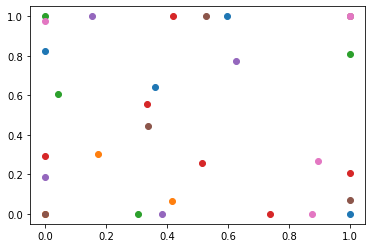

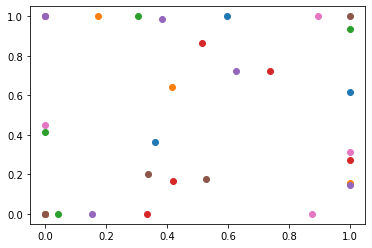

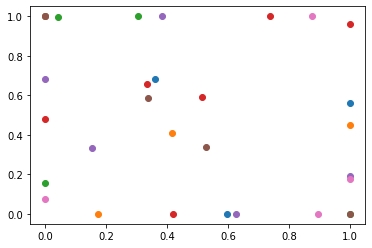

In [67]:
posind =0
for p in range(len(data_read_path)):
  plt.scatter(all_path_data[p][0][posind][:,0],all_path_data[p][0][posind][:,1])
    #plt.scatter(all_path_data[p][0][0,:,:])
 # print(all_path_data[p][0][posind])
#model = LinearRegression().fit(x, y)
plt.figure()
posind =1
for p in range(len(data_read_path)):
  plt.scatter(all_path_data[p][0][posind][:,0],all_path_data[p][0][posind][:,1])
plt.figure()
posind =2
for p in range(len(data_read_path)):
  plt.scatter(all_path_data[p][0][posind][:,0],all_path_data[p][0][posind][:,1])

#print(all_path_data[0][0])

In [68]:
#import matplotlib.pyplot as plt

#fig= plt.figure()

#f = np.array(range(gmmcomp))
#for i, txt in enumerate(f):
   # plt.annotate(txt, (gm.means_[i,0], gm.means_[i,1]))
    
#plt.scatter(gm.means_[:, 0], gm.means_[:, 1])
#plt.show()
#fig.savefig('mapofplaces.png')

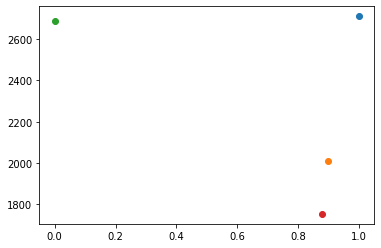

In [69]:
  fig = plt.figure()

  for a in range(len(list_tag)):
      gmpred = (gm.predict(main_data[a,:,:])   ).astype(int)
      #plt.plot(gmpred )
      plt.scatter(correlations[a] , len(gmpred[gmpred==0]))
      
  fig.savefig('dominanceVsHome0.png')

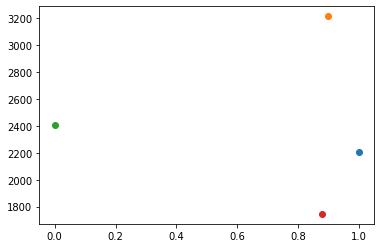

In [70]:
fig = plt.figure()

for a in range(len(list_tag)):
    gmpred = (gm.predict(main_data[a,:,:])   ).astype(int)
    #plt.plot(gmpred )
    plt.scatter(correlations[a] , len(gmpred[gmpred==1]))
    
fig.savefig('dominanceVsHome1.png')

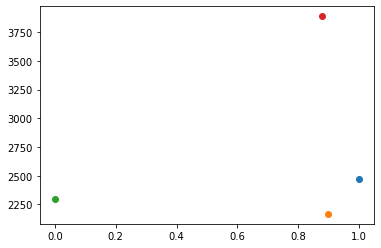

In [71]:
fig = plt.figure()

for a in range(len(list_tag)):
    gmpred = (gm.predict(main_data[a,:,:])   ).astype(int)
    #plt.plot(gmpred )
    plt.scatter(correlations[a] , len(gmpred[gmpred==2]))
    
fig.savefig('dominanceVsHome2.png')

20493
20493
20493
20493
20632
20632
20493


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


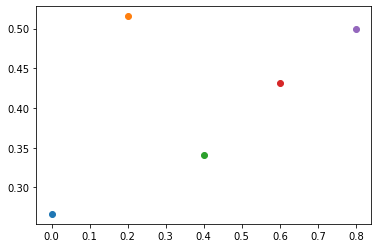

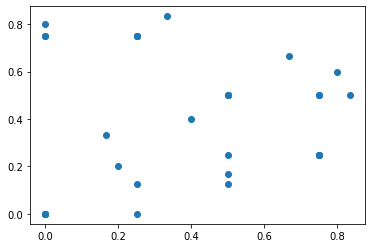

In [72]:
#dict_of_colony = {RFID: (w,AL)}
#dict_of_info = 
#all_path_data.append((all_cor_for_pos_list, gm.means_, list_tag, correlations))

#צריך לנרמל לפי מספר הפעמים שעטלף השתתף בניסוי


corelation_arm_list = []

for a in range(len(all_path_data)):
  list_tag_tempy = all_path_data[a][2]
  for b in range(len(list_tag_tempy)):
    cor_temp =np.where(np.sort(all_path_data[a][3]) == all_path_data[a][3][b])[0] / len(list_tag_tempy)
 
    tmpallweight = []
    for t1 in range(len(list_tag_tempy)):
        tmpallweight.append( dict_of_colony[  dict_of_info[a][   list_tag_tempy[t1]   ]    ][1])
    
    all_weight =np.sort(np.array(tmpallweight))
    my_weight =  dict_of_colony[  dict_of_info[a][   list_tag_tempy[b]   ]    ][1]
    if(my_weight< 80 or my_weight == -1):
      continue
  #  print(all_weight)
    weight_temp = np.mean(np.where(all_weight ==my_weight)) / len(list_tag_tempy)
    if(weight_temp > 0.7):
       print( dict_of_info[a][   list_tag_tempy[b]   ])
   # print(weight_temp)
    corelation_arm_list.append((cor_temp, weight_temp))
    #corelation_arm_list.append((cor_temp[0], dict_of_colony[  dict_of_info[a][   list_tag_tempy[b]   ]    ][0]))
corelation_arm_list = np.array(corelation_arm_list)

#plt.figure()
for i in range (5):

  plt.scatter(i*0.2, np.mean(corelation_arm_list[(corelation_arm_list[:,0] > (i*0.2))&(corelation_arm_list[:,0] <= ((i+1)*0.2)),1]))
plt.savefig('dominanceVsWeight.png')

plt.figure()
plt.scatter(corelation_arm_list[:,0], corelation_arm_list[:,1])
#print(np.corrcoef(corelation_arm_list[:,0], corelation_arm_list[:,1]))






[20493, 20528, 20516, 20488, 20547, 62438, 20522, 20632, 20513, 20529, 20595]


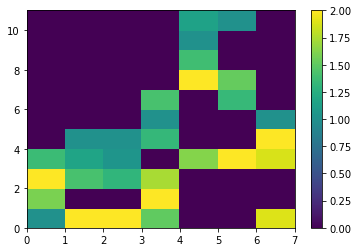

In [73]:

rfid_list = {}

for a in range(len(all_path_data)):
  list_tag_tempy = all_path_data[a][2]
  for b in range(len(list_tag_tempy)):
      my_rfid = (dict_of_info[a][int(all_path_data[a][2][b])])
    #  print(my_rfid)
      if my_rfid not in rfid_list.keys():
        rfid_list[my_rfid] = np.zeros(len(all_path_data))
      
      rfid_list[my_rfid][a] = all_path_data[a][3][b] +1

temp_list =[]
index_of_rfids = []

for rfid in rfid_list:
  temp_list.append(rfid_list[rfid])
  index_of_rfids.append(rfid)

session_bats_dominnace_array  = np.array(temp_list)

plt.pcolormesh(session_bats_dominnace_array)
plt.colorbar()

print(index_of_rfids)
plt.savefig('DomiMap.png')
#fig.savefig('DomiMap.png')


[{20595: 0, 20632: 0, 20522: 0, 20516: 4764, 20493: 4092, 20616: 0, 20513: 0, 20488: 1039, 20528: 7641, 20547: 0, 62438: 0, 20592: 0, 20529: 0, 20453: 0}, {20595: 0, 20632: 0, 20522: 0, 20516: 1936, 20493: 1341, 20616: 0, 20513: 0, 20488: 1088, 20528: 0, 20547: 18132, 62438: 643, 20592: 0, 20529: 0, 20453: 0}, {20595: 0, 20632: 0, 20522: 0, 20516: 1053, 20493: 4431, 20616: 0, 20513: 0, 20488: 1489, 20528: 0, 20547: 5991, 62438: 0, 20592: 0, 20529: 0, 20453: 0}, {20595: 0, 20632: 0, 20522: 49069, 20516: 32580, 20493: 28688, 20616: 0, 20513: 0, 20488: 0, 20528: 40048, 20547: 47497, 62438: 43453, 20592: 0, 20529: 0, 20453: 0}, {20595: 65131, 20632: 65944, 20522: 0, 20516: 0, 20493: 0, 20616: 24592, 20513: 19570, 20488: 52776, 20528: 0, 20547: 0, 62438: 0, 20592: 0, 20529: 26670, 20453: 0}, {20595: 37731, 20632: 37623, 20522: 34178, 20516: 0, 20493: 0, 20616: 0, 20513: 0, 20488: 22100, 20528: 0, 20547: 14528, 62438: 0, 20592: 0, 20529: 0, 20453: 764}, {20595: 0, 20632: 0, 20522: 0, 20516: 

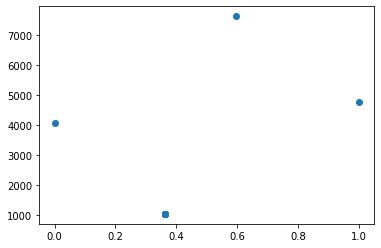

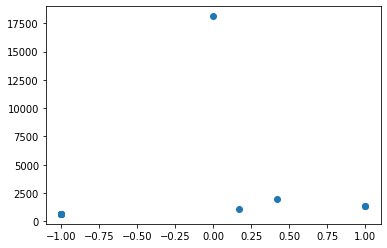

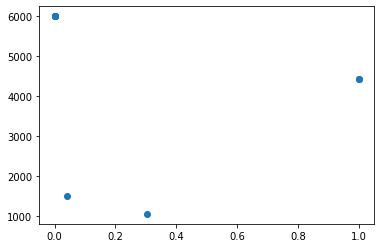

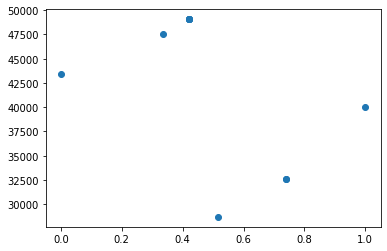

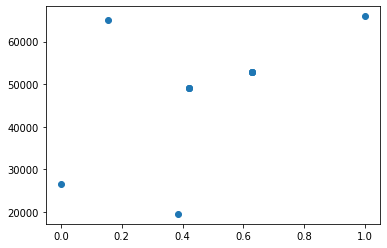

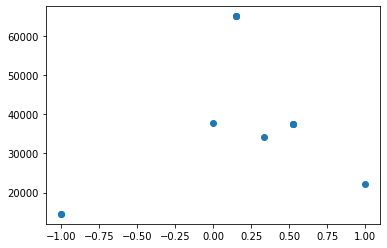

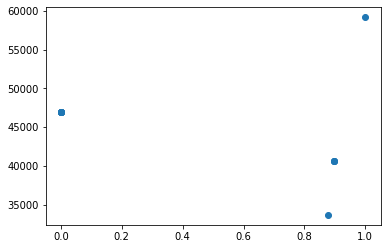

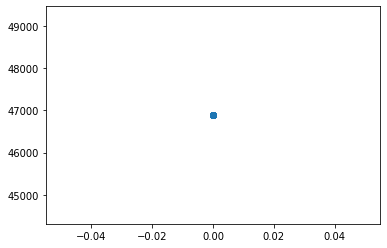

In [79]:
print(food_visit_aray)
sessionid = 0
listofresults = []
for sessionvisitarray in food_visit_aray:
  batdid = 0 
  for batrfid in index_of_rfids:
    if( sessionvisitarray[batrfid] > 0  ):
      visitstoofood = sessionvisitarray[batrfid]
      domofbat = session_bats_dominnace_array[batdid , sessionid ]
    listofresults.append((visitstoofood , domofbat , sessionid))
    batdid+=1

  sessionid += 1
listofresults = np.array(listofresults)

sessionid = 0
for sessionvisitarray in food_visit_aray:
  sessionidxs =  (listofresults[ :,2 ] == sessionid)
  plt.figure()
  plt.scatter(   listofresults[sessionidxs,1] - 1 , listofresults[sessionidxs,0])
  sessionid += 1